1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
import pandas as pd 
import numpy as np

In [4]:
file = "./data/data_000637.txt"
#read from file
d = pd.read_csv(file)
max_Nrows = d.shape[0] #or max_Nrows = len(d.index)  
min_N = 10000 
# N must be in [10.000; maximum number of rows] 
print("Num rows in dataframe = upper bound = ", max_Nrows, "\nlower bound = ", min_N)
if max_Nrows < min_N:
    N = min_N #at least N must be = 10000 --> I choose the minimum number of the interval
else:
    N = 20000 #if max_Nrows > 10000 --> I choose N=20000 since reading the whole dataset 
              #makes the computation time too long

data = d[:N]
print(data)

Num rows in dataframe = upper bound =  1310720 
lower bound =  10000
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
19995     1     0           27  3869200366        2513        29
19996     1     0           63  3869200366        2517         6
19997     1     0           32  3869200366        2519         5
19998     1     0           17  3869200366        2522        21
19999     1     0           64  3869200366        2522         0

[20000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [5]:
#the ORBIT_CNT is increased every x BX_COUNTER
#we want to know how many BX are contained in a orbit
bxcounter = data.loc[:,('ORBIT_CNT','BX_COUNTER')]
print(bxcounter)
#group by orbit and find the max value of counter for each orbit
orbit_max_counter = bxcounter.groupby('ORBIT_CNT')["BX_COUNTER"].max()
print("\nmax value of BX_COUNTER for each ORBIT_CNT\n", orbit_max_counter)
#find the max value in absolute
x = max(orbit_max_counter) #max value of counter 
print("\nmax value of BX_COUNTER that has been reached is", x, "\n")

#I make an additional control
#I've to check if in the dataframe, the value after maxC is equal to zero and the 2 orbits are different 
#--> this means that the counter has been reset
print(f"I make an additional control\nI check if the max bx_counter found, which is equal to %d" %x, "is followed by a bx_counter = 0\n") 
for i in bxcounter.index:
    if(bxcounter["BX_COUNTER"][i] == x and bxcounter["BX_COUNTER"][i+1]==0):
        print("max value reached is", bxcounter["BX_COUNTER"][i], "in the orbit", bxcounter['ORBIT_CNT'][i])
        print("the next value is ", bxcounter["BX_COUNTER"][i+1], "in the orbit", bxcounter['ORBIT_CNT'][i+1], "\n")


'''
OBS: Based on values plot before, the bx_counter is reset everytime it reaches the value 3563 
'''

        ORBIT_CNT  BX_COUNTER
0      3869200167        2374
1      3869200167        2374
2      3869200167        2553
3      3869200167        2558
4      3869200167        2760
...           ...         ...
19995  3869200366        2513
19996  3869200366        2517
19997  3869200366        2519
19998  3869200366        2522
19999  3869200366        2522

[20000 rows x 2 columns]

max value of BX_COUNTER for each ORBIT_CNT
 ORBIT_CNT
3869200167    3187
3869200168    3538
3869200169    2766
3869200170    3377
3869200171    3542
              ... 
3869200362    3425
3869200363    3460
3869200364    3352
3869200365    2787
3869200366    2522
Name: BX_COUNTER, Length: 200, dtype: int64

max value of BX_COUNTER that has been reached is 3563 

I make an additional control
I check if the max bx_counter found, which is equal to 3563 is followed by a bx_counter = 0

max value reached is 3563 in the orbit 3869200195
the next value is  0 in the orbit 3869200196 

max value reached is 3563 in t

'\nOBS: Based on values plot before, the bx_counter is reset everytime it reaches the value 3563 \n'

3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [6]:
import datetime as dt
today = dt.date.today()
#timing information: 
#a unit of TDC_MEAS corresponds to 25/30 ns
#a unit of BX_COUNTER corresponds to 25 ns
#in a orbit we've estimated circa x = 3563 units of BX_COUNTER
x = 3563
def computing_ns(e: pd.Series):
    return e['TDC_MEAS']*(25/30) + e['BX_COUNTER']*25 + e['ORBIT_CNT']*(x*25)

#the offset to the absolute time is the time computed in the first entry
first_entry = data.loc[0, ['ORBIT_CNT','BX_COUNTER','TDC_MEAS']]
offset = -(computing_ns(first_entry))
print("offset to apply such that the start of the data acquisition is 0ns --> ", offset, "\n")


times = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    times[i] = computing_ns(data.loc[i,['ORBIT_CNT','BX_COUNTER','TDC_MEAS']]) + offset
data_mod = data.copy()
data_mod["ABSOLUTE TIME(ns)"] = times
print(data_mod)

#convert the new column to a Time Series
print("\nConvert the new column to a Time Series")
data_mod["ABSOLUTE TIME(ns)"] = pd.to_datetime(data_mod["ABSOLUTE TIME(ns)"] , unit='ns', origin=today)
print(data_mod)

offset to apply such that the start of the data acquisition is 0ns -->  -344649004934896.7 

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0         1     0          123  3869200167        2374        26   
1         1     0          124  3869200167        2374        27   
2         1     0           63  3869200167        2553        28   
3         1     0           64  3869200167        2558        19   
4         1     0           64  3869200167        2760        25   
...     ...   ...          ...         ...         ...       ...   
19995     1     0           27  3869200366        2513        29   
19996     1     0           63  3869200366        2517         6   
19997     1     0           32  3869200366        2519         5   
19998     1     0           17  3869200366        2522        21   
19999     1     0           64  3869200366        2522         0   

       ABSOLUTE TIME(ns)  
0           0.000000e+00  
1           8.125000e-01  
2        

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [7]:
'''NB: reading the whole dataset makes the computation time too long, so I've decided to read only 10000 rows'''

ts = pd.to_datetime(data_mod["ABSOLUTE TIME(ns)"], format='%H:%M:%S')
print(ts)

0       2023-12-07 00:00:00.000000000
1       2023-12-07 00:00:00.000000000
2       2023-12-07 00:00:00.000004352
3       2023-12-07 00:00:00.000004608
4       2023-12-07 00:00:00.000009728
                     ...             
19995   2023-12-07 00:00:00.017729280
19996   2023-12-07 00:00:00.017729536
19997   2023-12-07 00:00:00.017729536
19998   2023-12-07 00:00:00.017729536
19999   2023-12-07 00:00:00.017729536
Name: ABSOLUTE TIME(ns), Length: 20000, dtype: datetime64[ns]


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [8]:
nc = data.copy()
noisy_channels = nc.groupby("TDC_CHANNEL").count()
#I could print only a column, since the result of count() is repeated for each column --> print(noisy_channels.loc[:, noisy_channels.columns[0]]
#but i prefer removing the other columns and rename the first 
noisy_channels = noisy_channels.drop(columns=["FPGA","ORBIT_CNT","BX_COUNTER","TDC_MEAS"]).rename(columns={"HEAD":"num TDC channels"})
print(noisy_channels)
s = noisy_channels.sort_values(by="num TDC channels", ascending=False)
print("\n3 TDC channels with most counts\n", s[0:3])

             num TDC channels
TDC_CHANNEL                  
1                         448
2                         502
3                         379
4                         415
5                         275
...                       ...
125                         7
126                         9
127                        21
128                        25
139                      1693

[129 rows x 1 columns]

3 TDC channels with most counts
              num TDC channels
TDC_CHANNEL                  
139                      1693
64                        996
63                        969


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
#non empty = at least one hit
orbits = d['ORBIT_CNT']
print("Orbits\n")
print(orbits)
s = orbits.sort_values().drop_duplicates()
print("\nOrbits sorted and unique\n", s.values)
print("\nTotal number of orbits we have: ", s.shape[0])

print("\nnumber of orbits we should have (if there wouldn't be any missing orbit):")
print((s.max()-s.min() + 1), "\n")

empty_orbits_counter = 0

print("\nFIRST METHOD")
expected = s[s.index[0]]
for i in range(s.shape[0]):
    if s[s.index[i]]!= expected:
        while(s[s.index[i]]!= expected):
            print("Empty orbit found -> it's missing orbit number", expected)
            empty_orbits_counter += 1 
            expected += 1
    expected += 1
print("number of empty orbits:")
print(empty_orbits_counter)

empty_orbits_counter = 0
print("\nSECOND METHOD")
for i in range(s.shape[0]-1):
    if s[s.index[i]] + 1 != s[s.index[i+1]]:
        empty_orbits_counter += 1
        print("Found a missing orbit --> ", s[s.index[i]] + 1 )
        print("Instead we have --> ", s[s.index[i+1]])
print("number of empty orbits:")
print(empty_orbits_counter)


Orbits

0          3869200167
1          3869200167
2          3869200167
3          3869200167
4          3869200167
              ...    
1310715    3869211171
1310716    3869211171
1310717    3869211171
1310718    3869211171
1310719    3869211171
Name: ORBIT_CNT, Length: 1310720, dtype: int64

Orbits sorted and unique
 [3869200167 3869200168 3869200169 ... 3869211169 3869211170 3869211171]

Total number of orbits we have:  11001

number of orbits we should have (if there wouldn't be any missing orbit):
11005 


FIRST METHOD
Empty orbit found -> it's missing orbit number 3869201471
Empty orbit found -> it's missing orbit number 3869201573
Empty orbit found -> it's missing orbit number 3869202170
Empty orbit found -> it's missing orbit number 3869206210
number of empty orbits:
4

SECOND METHOD
Found a missing orbit -->  3869201471
Instead we have -->  3869201472
Found a missing orbit -->  3869201573
Instead we have -->  3869201574
Found a missing orbit -->  3869202170
Instead we have 

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [41]:
#FIRST METHOD
'''
dchannel = data.query('TDC_CHANNEL==139')
print("measurement from TDC_CHANNEL=139\n", dchannel)
dchannel = dchannel.groupby('ORBIT_CNT').count().drop(columns=["FPGA","BX_COUNTER","TDC_MEAS", "HEAD"]).rename(columns={"TDC_CHANNEL":"num measurements from TDC_CHANNEL=139 in each orbit."})
print(dchannel)
print("\nNUMEBER of UNIQUE orbits with at least one measurement from TDC_CHANNEL = 139 --> ", dchannel.shape[0], "\n") 
'''

#SECOND METHOD --> Faster procedure
tdc139 = data.query('TDC_CHANNEL==139').groupby('ORBIT_CNT').count()
print("\nNUMEBER of UNIQUE orbits with at least one measurement from TDC_CHANNEL = 139 --> ", tdc139.shape[0])


NUMEBER of UNIQUE orbits with at least one measurement from TDC_CHANNEL = 139 -->  200


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [42]:
s0 = pd.Series(data.query("FPGA==0").groupby("TDC_CHANNEL").count().loc[:,data.columns[0]], index=data["TDC_CHANNEL"].drop_duplicates().sort_values().values)
s1 = pd.Series(data.query("FPGA==1").groupby("TDC_CHANNEL").count().loc[:,data.columns[0]], index=data["TDC_CHANNEL"].drop_duplicates().sort_values().values)
print("Series for FPGA = 0\n\nIndex = TDC_CHANNELS\n",s0.index, "\nValues\n", s0.values)
print("\n\nSeries for FPGA = 1\n\nIndex = TDC_CHANNELS\n",s1.index, "\nValues\n", s1.values)


Series for FPGA = 0

Index = TDC_CHANNELS
 Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       120, 121, 122, 123, 124, 125, 126, 127, 128, 139],
      dtype='int64', length=129) 
Values
 [  13.   23.   17.   22.   29.   23.   31.   38.   18.   28.   28.   nan
   30.   nan   24.   53.   31.   35.   42.   55.   32.   49.   56.   81.
   45.   75.   61.   95.   51.   nan   59.  101.   58.   nan   78.  110.
   98.  124.   nan  166.  112.  148.  143.  173.  157.  175.  202.  240.
  210.  243.  246.   nan  341.  375.   nan  463.  494.  523.  632.  686.
  726.  711.  961.  975.   15.   13.    2.   16.   21.   13.   29.   27.
   25.   24.   19.   21.   21.   19.   25.   24.   30.   42.   30.   37.
   32.   31.   35.   38.   34.   30.   20.   32.   19.   23.   14.   19.
    9.    5.    7.    8.    3.   10.    7.   10.    9.    6.    6.   10.
    9.   11.   19.   20.   26.   20.   28.   31.   46.   39.   60.   64.
   98.   94.  280.  258.   nan   nan   nan   nan 1171.]


S

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

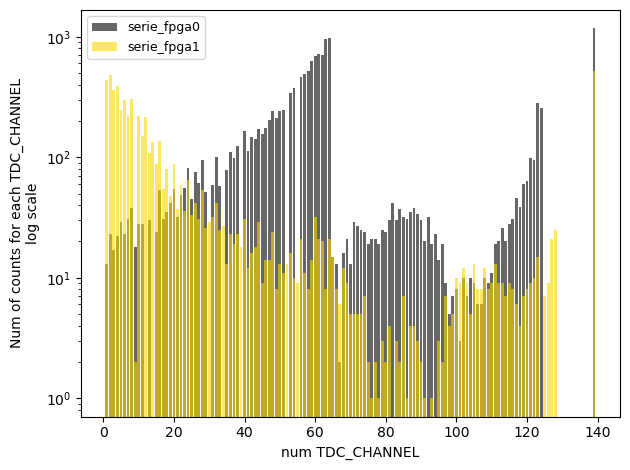

In [62]:
import matplotlib.pyplot as plt
fig, ax0 = plt.subplots(tight_layout=True)
plt.xlabel("num TDC_CHANNEL")
plt.ylabel("Num of counts for each TDC_CHANNEL\nlog scale")
plt.bar(s0.index, s0.values, alpha=0.6, color = 'black')
plt.bar(s1.index, s1.values, alpha=0.6, color = 'gold')
plt.legend(["serie_fpga0", "serie_fpga1"], fontsize= 9, loc ="upper left") 
plt.yscale('log')